<p style="width:35%;float:right;padding-left:50px">
<img src=http://www.geophysik.uni-muenchen.de/~igel/snap.png?raw=true>
<span style="font-size:smaller">
from <span style="font-style: italic">Nissen-Meyer et al. (2014). AxiSEM: broadband 3-D seismic wavefields in axisymmetric media. Solid Earth, 5(1), 425–445.</span>
</span>
</p>

# Computational Seismology 

## *Seismic Wavefield of a Double-Couple Point Source*

**Authors:** *Heiner Igel, David Vargas*


## Basic Equations

The fundamental analytical solution to the problem of a double couple point source in infinite homogeneous media (Aki and Richards - 2002) is implemented in this Ipython notebook. This solution of seimic waves in an infinite homogeneous medium provide fundamentamental information used as benchmark to understand kinematic properties of seismic sources, quasi-analytical solutions to wave propagation problems, and influence of earthquakes on crustal deformation. 

Simulations of 3D elastic wave propagation need to be validated by the use of analytical solutions. In order to evaluate how healty a numerical solution is, one may recreate conditions for which analytical solutions exist with the aim of reproduce and compare the different results. In this sense, the fundamental solution for the  double couple point source offers an alternative to achieve this quality control

We which to find the displacement wavefield $\mathbf{u}(\mathbf{x},t)$ at some distance $\mathbf{x}$ from a seismic moment tensor source with $M_{xz} = M_{zx} = M_0$. According to (Aki and Richards 2002), the displacement $\mathbf{u}(\mathbf{x},t)$ due to a double-couple point source in an infinite, homogeneous, isotropic medium is

\begin{align*}
\mathbf{u}(\mathbf{x},t) &= \dfrac{1}{4\pi\rho} \mathbf{A}^N \dfrac{1}{r^4} \int_{{r}/{\alpha}}^{{r}/{\beta}} \tau M_o(t-\tau)d\tau +\\
&+\dfrac{1}{4\pi\rho\alpha^2}\mathbf{A}^{IP}\dfrac{1}{r^2} M_o(t-{r}/{\alpha}) +\dfrac{1}{4\pi\rho\beta^2}\mathbf{A}^{IS}\dfrac{1}{r^2} M_o(t-{r}/{\beta})+\\
&+\dfrac{1}{4\pi\rho\alpha^3}\mathbf{A}^{FP}\dfrac{1}{r} \dot M_o(t-{r}/{\alpha}) +\dfrac{1}{4\pi\rho\beta^3}\mathbf{A}^{FS}\dfrac{1}{r} \dot M_o(t-{r}/{\beta})
\end{align*}

where the radiation patterns $\mathbf{A}^N$ (near-field), $\mathbf{A}^{IP}$ (intermediate-field P wave), $\mathbf{A}^{IS}$ (intermediate-field S wave), $\mathbf{A}^{FP}$ (far-field P wave) and $\mathbf{A}^{FS}$ (far-field S wave) are:

\begin{align*}
\mathbf{A}^N &= 9sin(2\theta)cos(\phi)\hat{\mathbf{r}} - 6(cos(2\theta)cos(\phi)\hat{\mathbf{\theta}} - cos(\theta)sin(\phi))\hat{\mathbf{\phi}}\\
\mathbf{A}^{IP} &= 4sin(2\theta)cos(\phi)\hat{\mathbf{r}} - 2(cos(2\theta)cos(\phi)\hat{\mathbf{\theta}} - cos(\theta)sin(\phi))\hat{\mathbf{\phi}}\\
\mathbf{A}^{IS} &= -3sin(2\theta)cos(\phi)\hat{\mathbf{r}} + 3(cos(2\theta)cos(\phi)\hat{\mathbf{\theta}} - cos(\theta)sin(\phi))\hat{\mathbf{\phi}}\\ 
\mathbf{A}^{FP} &= sin(2\theta)cos(\phi)\hat{\mathbf{r}}\\
\mathbf{A}^{FS} &= cos(2\theta)cos(\phi)\hat{\mathbf{\theta}} - cos(\theta)sin(\phi)\hat{\mathbf{\phi}}
\end{align*}

The parameters one have to consider include: receiver coordinates $\mathbf{x}$, density of the medium $\rho$, S-Wave velocity $\beta$, p-wave velocity $\alpha$, and the desired time dependent seismic moment function $M_o(t)$.On the other hand, integrations limits are determined by the propagation time from source to receiver for both p-waves and s-waves ie. ${r}/{\beta}$ and ${r}/{\alpha}$ respectively.

This is a solution in spherical coordinates. Since we normally measure displacements in cartesian coordinates, it is necessary to implement a change of coordinates if we want to visualize the solution in cartesian coordinates. 


In [18]:
"""
Created on Tue Feb  9 06:32:15 2016
"""
# Please run it before you start the simulation!
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import quad
from numpy import sin, cos, arccos, arctan,  pi, sign, sqrt
from numpy import vectorize, linspace, asarray, outer, diff, savetxt

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

## 2. Coordinate transformation methods

In [19]:
def sph2cart(r, th, phi):
    '''
    Transform spherical coordinates to cartesian
    '''
    x = r * sin(th) * cos(phi)
    y = r * sin(th) * sin(phi)
    z = r * cos(th)   
    return x, y, z
    
def cart2sph(x, y, z):
    '''
    Transform cartesian coordinates to spherical
    '''
    r = sqrt(x**2 + y**2 + z**2)
    th = arccos(z/r)
    phi = arctan(y/x)
    return r, th, phi 

## 3. COMPUTE AKI & RICHARDS SOLUTION

<IPython.core.display.Javascript object>


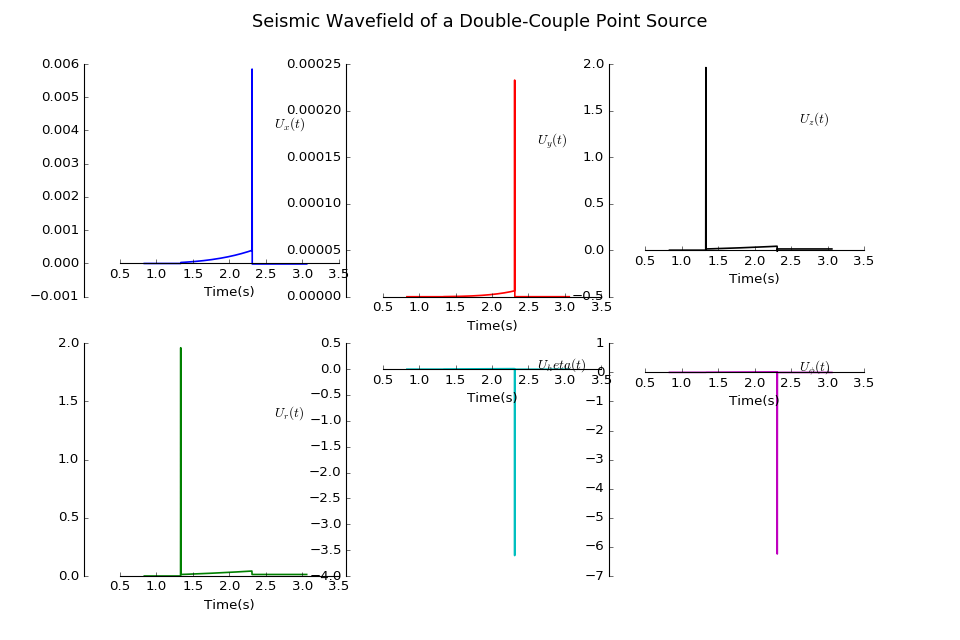

In [21]:
#%% Initialization of setup
# -----------------------------------------------------------------------------
x = 4000   # x receiver coordinate 
y = 4000   # y receiver coodinate
z = 4000   # z receiver coodinate

rho   = 2500              # Density kg/m^3 
beta  = 3000              # S-wave velocity
alpha = sqrt(3)*beta      # p-wave velocity

stf   = 'heaviside'           # Set the desired source time function 'heaviside' , 'gauss'
Trise = 0.25              # Rise time used in the source time function 
Mo    = 4*10E16           # Scalar Moment 
    
r, th, phi = cart2sph(x, y, z)     # spherical receiver coordinates  

tmin = r/alpha - 2*Trise           # Minimum observation time 
#tmin = 0
tmax = r/beta + Trise + 2*Trise    # Maximum observation time 

# SOURCE TIME FUNCTION
# -----------------------------------------------------------------------------   
if stf == 'heaviside':
    M0 = lambda t: 0.5*Mo*0.5*(sign(t) + 1)
if stf == 'gauss':
    M0 = lambda t: Mo*(1 + erf(t/Trise))

#******************************************************************************
# COMPUTE AKI & RICHARDS SOLUTION
#******************************************************************************
# Scalar factors int the AKI & RICHARDS solution
# -----------------------------------------------------------------------------
CN  = (1/(4 * pi * rho)) 
CIP = (1/(4 * pi * rho * alpha**2))
CIS = (1/(4 * pi * rho * beta**2))
CFP = (1/(4 * pi * rho * alpha**3))
CFS = (1/(4 * pi * rho * beta**3))

# Radiation patterns: near(AN), intermedia(AIP,AIS), and far(AFP,AFS) fields  
# -----------------------------------------------------------------------------
def AN(th, phi):    
    AN = [[9*sin(2*th)*cos(phi), -6*cos(2*th)*cos(phi), 6*cos(th)*sin(phi)]]
    return asarray(AN)
    
def AIP(th, phi):    
    AIP = [[4*sin(2*th)*cos(phi), -2*cos(2*th)*cos(phi), 2*cos(th)*sin(phi)]]
    return asarray(AIP)
    
def AIS(th, phi):    
    AIS = [-3*sin(2*th)*cos(phi), 3*cos(2*th)*cos(phi), -3*cos(th)*sin(phi)]
    return asarray(AIS)
    
def AFP(th, phi):    
    AFP = [sin(2*th)*cos(phi), 0, 0 ]
    return asarray(AFP)
    
def AFS(th, phi):    
    AFS = [0, cos(2*th)*cos(phi), -cos(th)*sin(phi)]
    return asarray(AFS)

# Calculate integral in the right hand side of AKI & RICHARDS solution
# -----------------------------------------------------------------------------
integrand = lambda  tau, t: tau*M0(t - tau)

def integral(t):
    return quad(integrand, r/alpha, r/beta, args=(t))[0]

vec_integral = vectorize(integral)

# Assemble the total AKI & RICHARDS solution
# -----------------------------------------------------------------------------
t = linspace(tmin, tmax, 1000) 
UN =   CN * (1/r**4) * outer(AN(th, phi), vec_integral(t))
UIP = CIP * (1/r**2) * outer(AIP(th, phi), M0(t - r/alpha)) 
UIS = CIS * (1/r**2) * outer(AIS(th, phi), M0(t - r/beta))

t, dt = linspace(tmin, tmax, 1001, retstep=True) # diff() return N-1 size vector  
UFP = CFP * (1/r) * outer(AFP(th, phi), diff(M0(t - r/alpha))/dt)
UFS = CFS * (1/r) * outer(AFS(th, phi), diff(M0(t - r/beta))/dt)
t = linspace(tmin, tmax, 1000) 

U = UN + UIP + UIS + UFP + UFS

Ur, Uth, Uphi = U[0,:], U[1,:], U[2,:]  # spherical componets of the field u 
Ux, Uy, Uz = sph2cart(Ur, Uth, Uphi)    # spherical to cartesian coordinates
#******************************************************************************

# Plotting
# -----------------------------------------------------------------------------
seis = [Ux, Uy, Uz, Ur, Uth, Uphi]  # Collection of seismograms
labels = ['$U_x(t)$','$U_y(t)$','$U_z(t)$','$U_r(t)$','$U_\theta(t)$','$U_\phi(t)$']
cols = ['b','r','k','g','c','m']

# Initialize animated plot
fig = plt.figure(figsize=(12,8), dpi=80)

fig.suptitle("Seismic Wavefield of a Double-Couple Point Source", fontsize=16)
plt.ion() # set interective mode
plt.show()

for i in range(6):              
    st = seis[i]
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(t, st, lw = 1.5, color=cols[i])  
    ax.set_xlabel('Time(s)')
    ax.text(tmin+0.8*(tmax-tmin), 0.7*max(st), labels[i])
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

savetxt('seis.csv', (t, Ux, Uy, Uz, Ur, Uth, Uphi)) # Export the data as seis.csv in the given order       
plt.savefig('Fig_2.4.png') # save the figure
plt.show()